In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("data/train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

In [3]:
test = pd.read_csv("data/test.csv", parse_dates=["datetime"])
test.shape

(6493, 9)

## Feature Engineering

In [4]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 16)

In [5]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['hour'] = test['datetime'].dt.hour
test['dayofweek'] = test['datetime'].dt.dayofweek
test.shape

(6493, 13)

In [6]:
rfModel_wind = RandomForestRegressor()
f_columns = ['season','weather','humidity','month','temp','year','hour','dayofweek','atemp']
X_train = train[f_columns]
y_r_label = train['registered']
y_c_label = train['casual']
print(X_train.shape)
print(y_r_label.shape)
print(y_c_label.shape)

(10886, 9)
(10886,)
(10886,)


In [7]:
X_test = test[f_columns]
X_test.shape

(6493, 9)

In [8]:
rfModel = RandomForestRegressor()
rfModel.fit(X_train, y_r_label)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [9]:
testRegisteredValues = rfModel.predict(X_test)

In [10]:
test['registered'] = testRegisteredValues
test['registered'].isnull().sum()

0

In [11]:
rfModel.fit(X_train, y_c_label)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [12]:
testCasualValues = rfModel.predict(X_test)
test['casual'] = testCasualValues
test['casual'].isnull().sum()

0

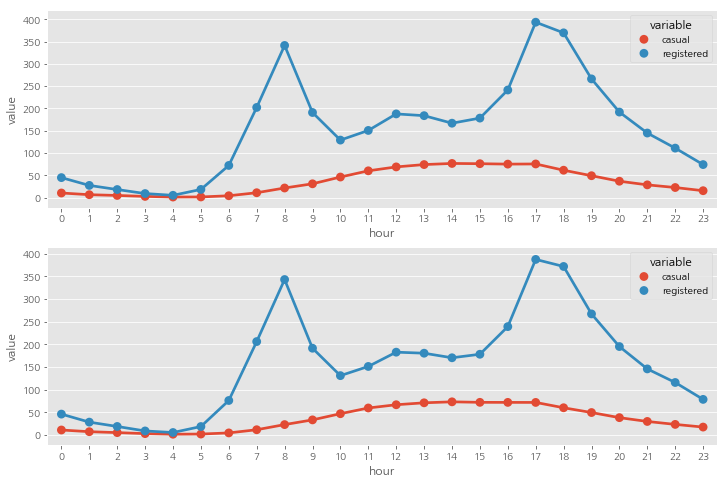

In [13]:
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(12,8)

hourTransformed = pd.melt(train[['hour','casual','registered']], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(['hour','variable'],sort=True)['value'].mean()).reset_index()
sns.pointplot(x=hourAggregated['hour'], y=hourAggregated['value'],hue=hourAggregated['variable'],hue_order=['casual','registered'], data=hourAggregated, join=True, ax=ax1)


hourTransformed = pd.melt(test[['hour','casual','registered']], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(['hour','variable'],sort=True)['value'].mean()).reset_index()
sns.pointplot(x=hourAggregated['hour'], y=hourAggregated['value'],hue=hourAggregated['variable'],hue_order=['casual','registered'], data=hourAggregated, join=True, ax=ax2)

In [14]:
# train과 test 데이터셋을 합쳐준다.
data = train.append(test)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

In [15]:
# 풍속이 0인 데이터들의 값을 보정해 준다.

dataWind0 = data[data['windspeed']==0]
dataWindNot0 = data[data['windspeed']!=0]
rfModel_wind = RandomForestRegressor()
windColumns = ['season','weather','humidity','month','temp','year','atemp']
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0['windspeed'])

wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
dataWind0['windspeed'] = wind0Values
data = dataWindNot0.append(dataWind0)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

In [16]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):

    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)
        
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

In [17]:
categoricalFeatureNames = ['season','holiday','workingday','weather','dayofweek','year','hour']
numericalFeatureNames = ['temp','humidity','windspeed','atemp','casual','registered']
dropFeatures = ['count','datetime','month']

In [18]:
for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

In [19]:
X_train = data[pd.notnull(data['count'])].sort_values(by=['datetime'])
X_test = data[~pd.notnull(data['count'])].sort_values(by=['datetime'])
datetimecol = X_test['datetime']
y_train = X_train['count']

In [20]:
X_train  = X_train.drop(dropFeatures,axis=1)
X_test  = X_test.drop(dropFeatures,axis=1)

In [21]:
rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [22]:
preds = rfModel.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Random Forest: ",score)

RMSLE Value For Random Forest:  0.00522339464307


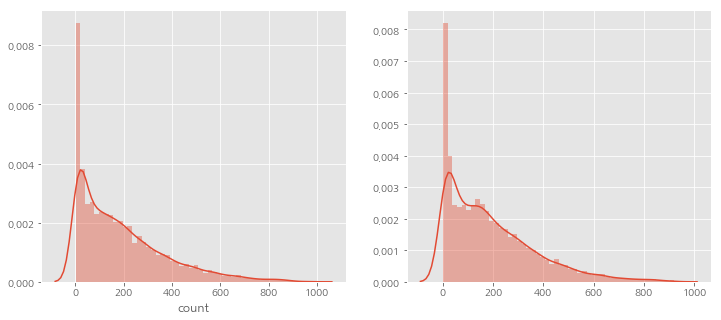

In [23]:
predsTest = rfModel.predict(X_test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)

In [24]:
submission = pd.read_csv("data/sampleSubmission.csv")
submission

submission["count"] = np.exp(predsTest)

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,14.0
1,2011-01-20 01:00:00,6.0
2,2011-01-20 02:00:00,4.0
3,2011-01-20 03:00:00,3.0
4,2011-01-20 04:00:00,3.0


In [25]:
submission.to_csv("data/Score_{0:.5f}_submission.csv".format(score), index=False)

In [26]:
# %ls data